In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [21]:
#!git reset --hard origin/master
#!git pull

In [22]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/](https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/)

This spreadsheet consists of three worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Prices&rdquo;, and a series of different years of food &ldquo;Expenditures&rdquo;.

Each worksheet has the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should
have one column for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Ugandan example that I wish to work
through.



In [23]:
Malawi_Data = '1-RiJTwSi5CfL4sNxDyOsyV0SkculNdwUbFKi1zfgWWM'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [24]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

x = read_sheets(Malawi_Data,sheet='Expenditures')
x.columns.name = 'j'
                 
# Change 'Uganda' to key of your own sheet in Sheets, above
d = read_sheets(Malawi_Data,sheet="HH Characteristics")
d.columns.name = 'k'

# x may have duplicate columns
x = x.groupby('j',axis=1).sum()
x = x.replace(0,np.nan) # Replace zeros with missing
x = x.set_index(['i','t','m'])
x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Take logs of expenditures; call this y
y = np.log(x.replace(0,np.nan).dropna(how='all'))

d.set_index(['i','t','m'],inplace=True)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


This gives a dataframe of household characteristics $d$ with a simple structure.



Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [25]:
d=d.xs(2004,level='t',drop_level=False).sample(n=5000, replace=False)


In [26]:
d.index

MultiIndex([(30101019060, 2004, 'Malawi'),
            (20203012245, 2004, 'Malawi'),
            (20801081016, 2004, 'Malawi'),
            (20674002329, 2004, 'Malawi'),
            (10201021062, 2004, 'Malawi'),
            (10505021214, 2004, 'Malawi'),
            (20603111053, 2004, 'Malawi'),
            (30301058127, 2004, 'Malawi'),
            (31202044040, 2004, 'Malawi'),
            (31201127134, 2004, 'Malawi'),
            ...
            (30534009931, 2004, 'Malawi'),
            (10407001104, 2004, 'Malawi'),
            (30604015063, 2004, 'Malawi'),
            (20684002207, 2004, 'Malawi'),
            (31001036375, 2004, 'Malawi'),
            (20510001118, 2004, 'Malawi'),
            (30901131172, 2004, 'Malawi'),
            (30508039078, 2004, 'Malawi'),
            (31106801147, 2004, 'Malawi'),
            (31007031054, 2004, 'Malawi')],
           names=['i', 't', 'm'], length=5000)

In [27]:
#y=y.xs(2004,level='t',drop_level=False)

There may be some goods that very few people consume&#x2014;too few to estimate demand reliably.   We have code to deal with this.  You can play with the `min_obs` parameter&#x2014;the larger it is, the more foods will be dropped.



In [28]:
#from cfe.estimation import drop_columns_wo_covariance

#y = drop_columns_wo_covariance(y,min_obs=30)

Now, we want the $d$ and $y$ dataframes to have rows that line up:



In [29]:
#use = y.index.intersection(d.index)
#y = y.loc[use,:]
#d = d.loc[use,:]

## Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
So, a first step is to turn our dataframe for `y` into a series, so we can put it on the left-hand side of this regression.  Then we need to make our dataframe $d$ conform:



In [30]:
y = y.stack()
d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

In [31]:
y.head()

i            t     m       j          
10101002025  2004  Malawi  Avocado        2.302585
                           Beef           5.075174
                           Cooking oil    3.401197
                           Salt           1.609438
                           Tomato         1.609438
dtype: float64

In [32]:
d.head()

i            t     m       k      
30101019060  2004  Malawi  M 0-3      0
                           M 4-8      1
                           M 9-13     0
                           M 14-18    0
                           M 19-30    1
dtype: int64

### Basic Estimation



Just one line to set up the regression:



In [33]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [34]:
result.predicted_expenditures()

i            t     m       j                                        
10101002246  2004  Malawi  Avocado                                      11.424194
                           Banana                                        7.089493
                           Bean, brown                                  29.283827
                           Beef                                         62.049227
                           Biscuits                                      8.117387
                                                                          ...    
31202086289  2004  Malawi  Tanaposi rape                                18.473847
                           Tea                                          11.731699
                           Tomato                                       37.552102
                           White sweet potato                           29.410335
                           Yeast, baking powder, bicarbonate of soda     6.265833
Length: 54150, dtype: float64

Now we can compare predicted log expenditures with actual:



<IPython.core.display.Javascript object>


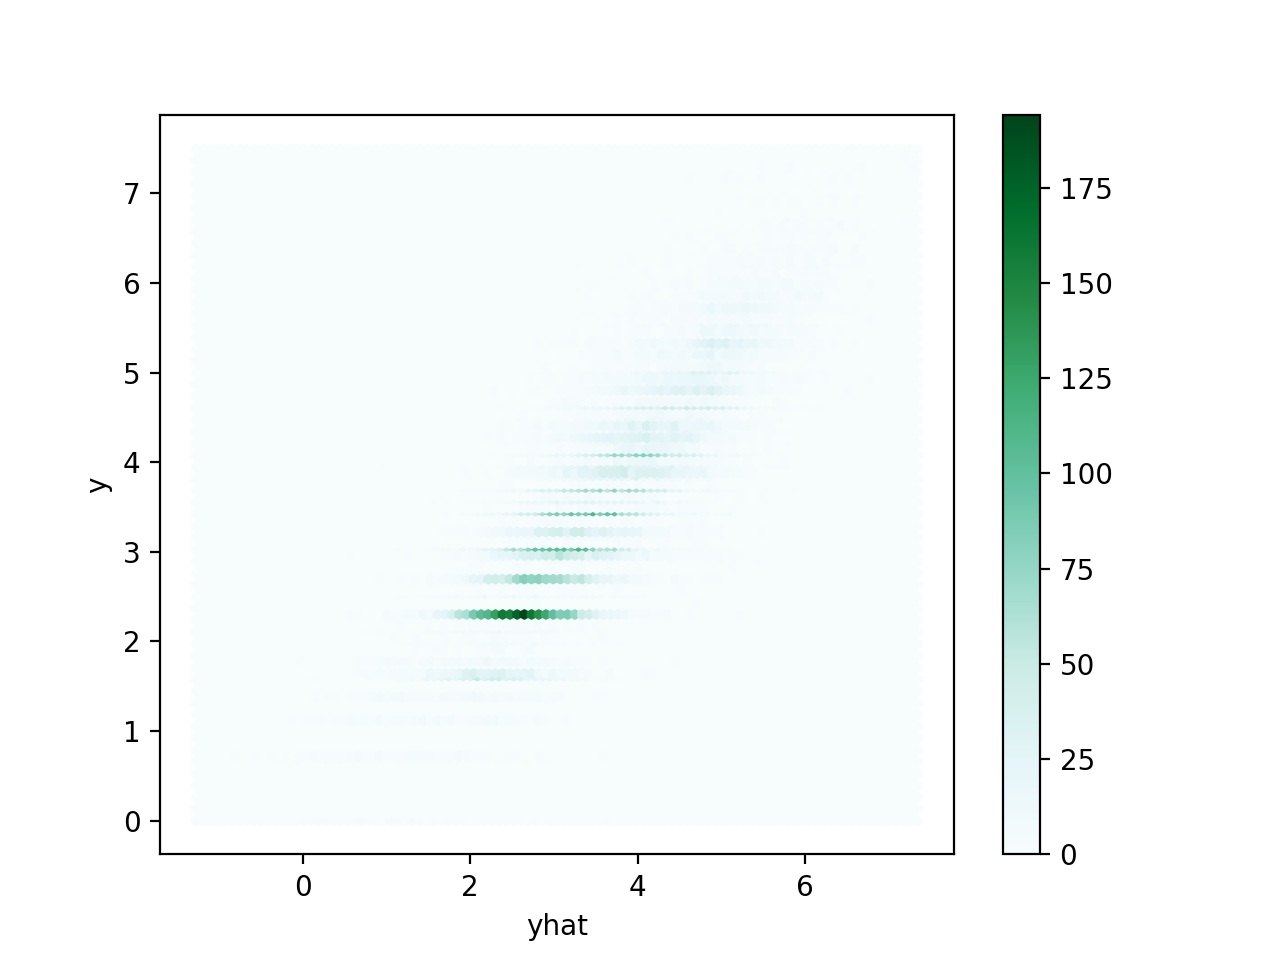

<AxesSubplot:xlabel='yhat', ylabel='y'>

In [35]:
%matplotlib notebook
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.hexbin(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



### Parameters



#### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.



In [36]:
result.get_beta().sort_values()

j
Maize ufa mgaiwa (normal flour)              0.031597
Maize ufa refined (fine flour)               0.083098
Nkwani                                       0.146763
Green maize                                  0.189652
Cabbage                                      0.213041
Cassava tubers                               0.228477
Bean, brown                                  0.230097
White sweet potato                           0.230759
Salt                                         0.237155
Tanaposi rape                                0.249796
Avocado                                      0.254330
Chicken                                      0.261242
Mandazi, doughnut (vendor)                   0.263310
Sugar cane                                   0.275987
Chips (vendor)                               0.285844
Buns, scones                                 0.290626
Sugar                                        0.293217
Groundnut flour                              0.313695
Dried fish                

Here we use a plot to visualize, with confidence intervals.



<IPython.core.display.Javascript object>


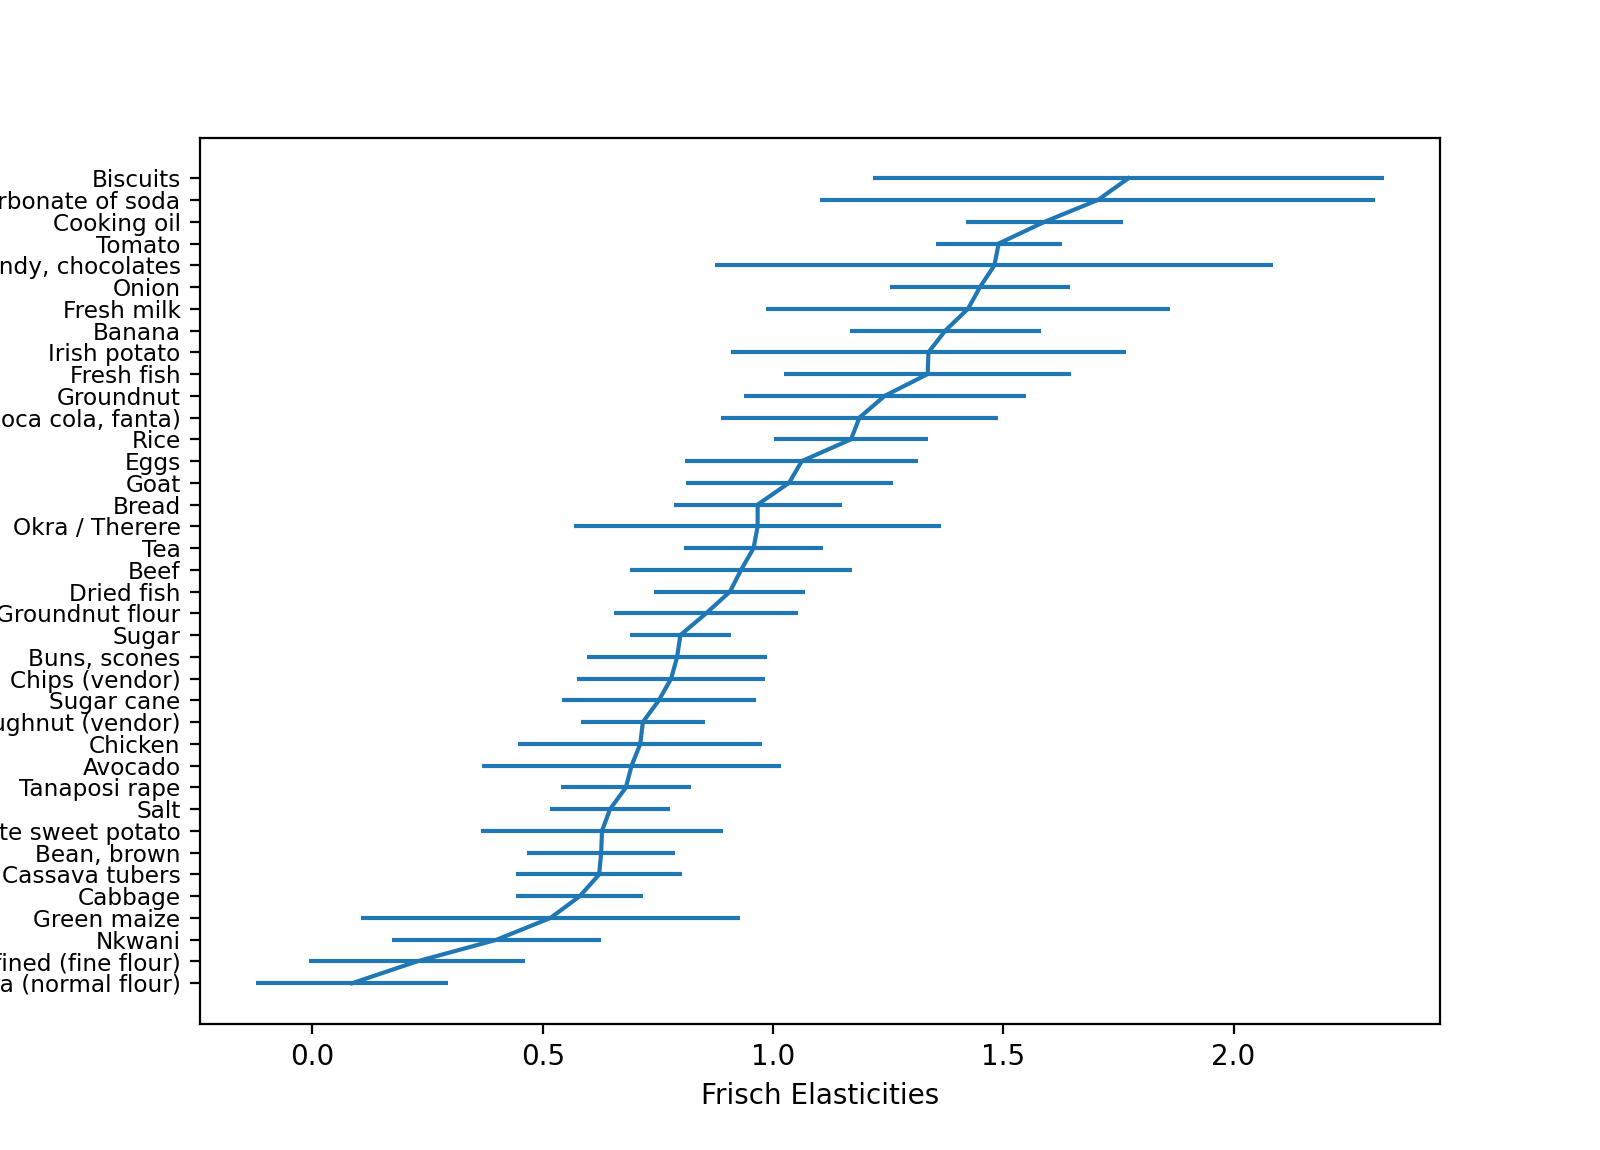

<IPython.core.display.Javascript object>


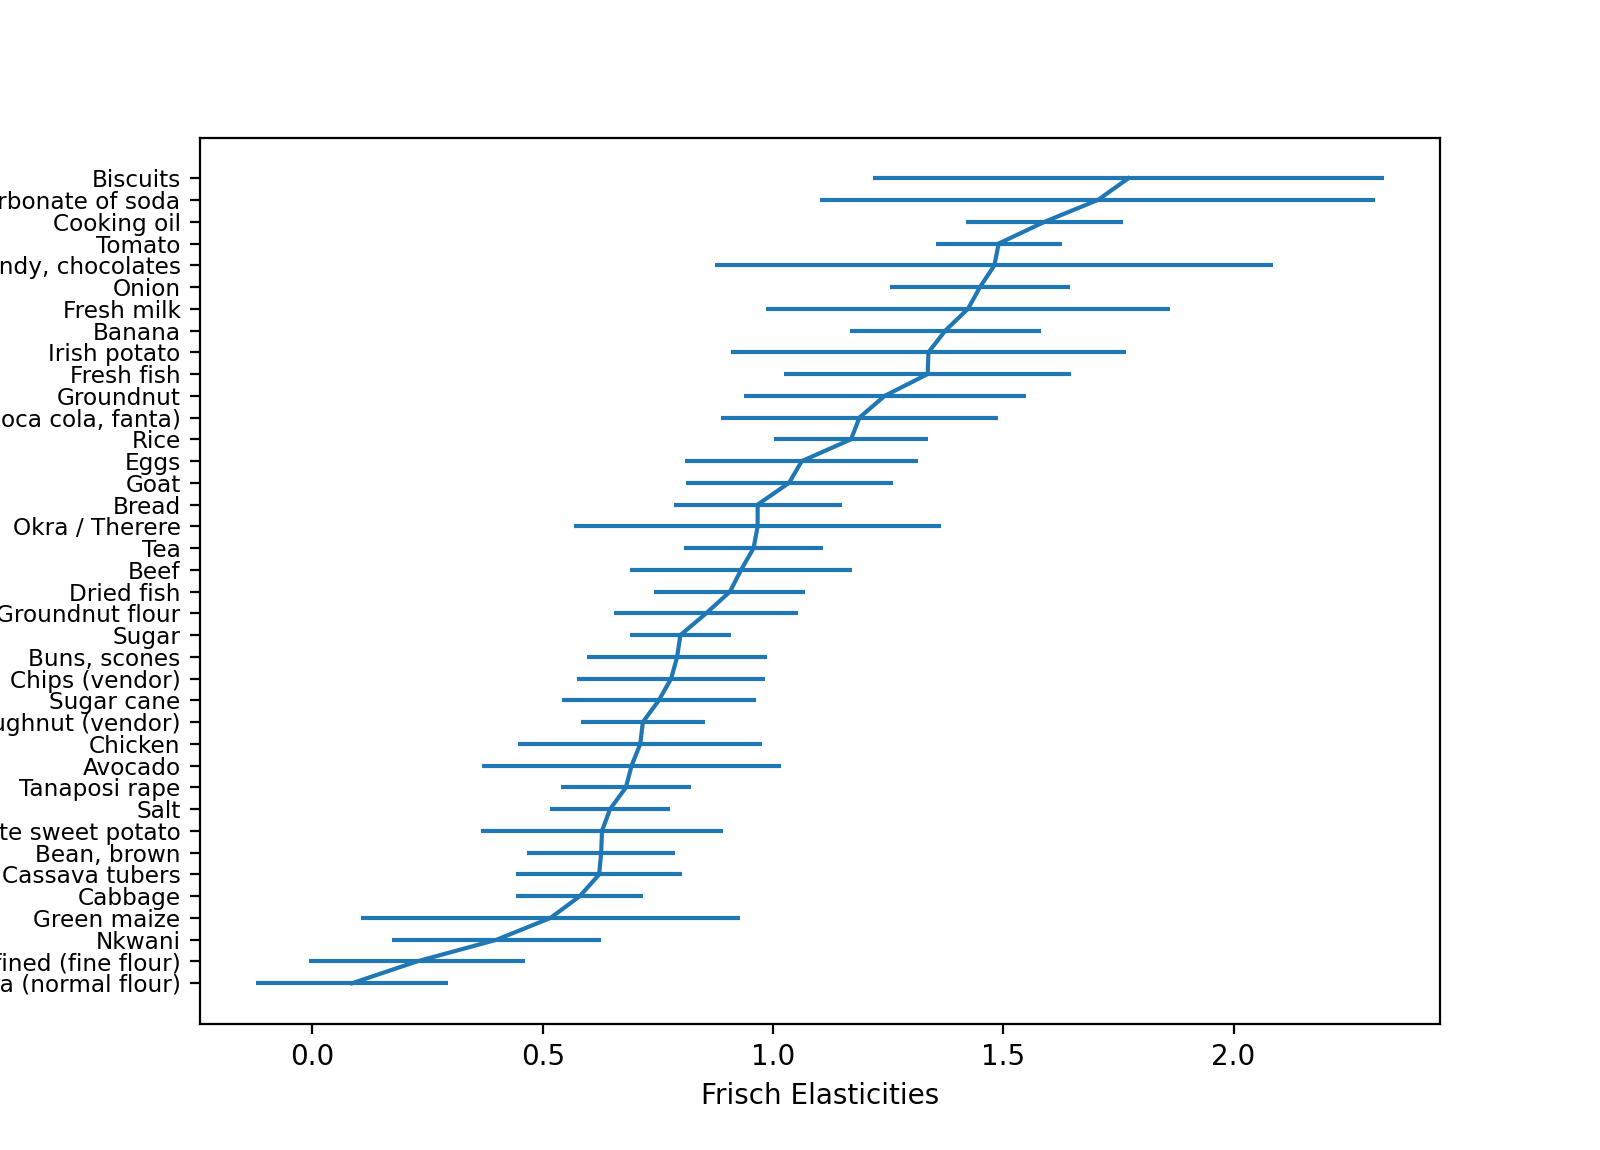

In [37]:
result.graph_beta()

#### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [38]:
result.gamma

k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Constant
j,,,,,,,,,,,,,,,
Avocado,-0.056890,0.056051,-0.079441,0.218028,0.186134,0.288110,0.045390,0.085644,0.118450,-0.152491,0.037365,0.238872,0.349142,0.103652,-0.613994
Banana,-0.105229,-0.078276,0.068695,0.123738,0.221474,0.404995,0.141874,-0.052394,-0.002351,0.053185,0.060868,0.209012,0.186400,-0.027405,-0.542948
"Bean, brown",0.038094,0.048829,-0.024804,0.096373,0.119806,0.145943,0.204596,-0.018197,0.027414,0.039371,0.090075,0.081079,0.183292,0.042041,-0.409667
Beef,-0.141265,-0.033397,0.141115,-0.024736,0.235347,0.389742,0.273773,-0.117295,0.057188,0.101217,0.093043,0.287493,0.215636,0.189765,-0.931697
Biscuits,0.039395,-0.154939,0.099745,-0.245951,0.112611,0.326811,-0.027196,-0.133921,-0.106648,0.149613,-0.134811,0.413480,0.493283,0.297981,-0.469283
Bread,-0.073927,-0.042740,0.060934,0.052267,0.246602,0.374759,0.198661,-0.156835,0.063224,-0.010986,0.087247,0.245411,0.113283,0.170288,-0.738136
"Buns, scones",-0.012171,0.050611,0.058275,-0.002924,0.181072,0.289776,0.107234,0.008583,0.022819,-0.103480,0.169466,0.191676,0.387175,0.112957,-0.527519
Cabbage,-0.024019,0.019593,0.058049,0.032151,0.150363,0.202867,0.211154,-0.090521,0.017153,-0.012391,0.091758,0.153647,0.142867,-0.012531,-0.405046
Cassava tubers,0.034885,0.104153,-0.033156,0.227725,0.177375,0.161338,0.032445,0.020996,0.097084,0.054535,0.110107,0.165246,0.136295,0.034342,-0.512785


### Saving Result



You can save the estimated result, using something like



In [39]:
result.to_pickle('my_estimates.pickle')

You can subsequently load this using



In [40]:
import cfe
result = cfe.regression.read_pickle('my_estimates.pickle')